# 기본 LSTM 모델 
LSTM을 제대로 활용하기 위해서는 상태유지 모드, 배치사이즈, 타임스텝, 속성에 대한 개념에 이해가 필요합니다
- 타임스텝이란 하나의 샘플에 포함된 시퀀스 개수입니다. 이는 앞서 살펴본 “input_length”와 동일합니다. 
- 윈도우 크기와 동일하게 타임스텝으로 설정하면 됩니다. 
- 설정한 LSTM 모델에 따라 입력할 데이터셋도 샘플 수, 타임스텝 수, 속성 수 형식으로 맞추어야 합니다. 

## 0. 사용할 패키지 불러오기 

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
import numpy as np

### 0.1 랜덤시드 고정하기 
동일한 결과를 얻기 위해 시드를 고정한다.

In [2]:
np.random.seed(5)

### 0.2 손실 이력 클래스 정의

In [3]:
class LossHistory(Callback):
    def init(self):
        self.losses = []
    
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))  
        

## 1. 데이터셋 생성
### 1.1 코드 변환 사전
* code2idx : 코드를 숫자로 변환 
* idx2code : 숫자를 코드로 변환

In [4]:
code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

### 1.2 데이터 셋 생성 함수 정의 
- 사전을 이용해서 순차적인 음표를 우리가 지정한 윈도우 크기만큼 잘라 데이터셋을 생성하는 함수를 정의

In [5]:
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

### 1.3 데이터 셋

In [6]:
# 시퀀스 데이터 정의 
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


### 1.4 데이터 준비 

#### 1.4.1 입력과 출력 변수로 분리 

In [15]:
x_train = dataset[:, 0:4]
y_train = dataset[:, 4]
max_idx_value = 13
print(x_train)
print(y_train)

[[11  9  2 10]
 [ 9  2 10  8]
 [ 2 10  8  1]
 [10  8  1  7]
 [ 8  1  7  8]
 [ 1  7  8  9]
 [ 7  8  9 10]
 [ 8  9 10 11]
 [ 9 10 11 11]
 [10 11 11  4]
 [11 11  4 11]
 [11  4 11  9]
 [ 4 11  9  9]
 [11  9  9  9]
 [ 9  9  9 10]
 [ 9  9 10  8]
 [ 9 10  8  1]
 [10  8  1  7]
 [ 8  1  7  9]
 [ 1  7  9 11]
 [ 7  9 11 11]
 [ 9 11 11  9]
 [11 11  9  9]
 [11  9  9  2]
 [ 9  9  2  8]
 [ 9  2  8  8]
 [ 2  8  8  8]
 [ 8  8  8  8]
 [ 8  8  8  8]
 [ 8  8  8  9]
 [ 8  8  9  3]
 [ 8  9  3  9]
 [ 9  3  9  9]
 [ 3  9  9  9]
 [ 9  9  9  9]
 [ 9  9  9  9]
 [ 9  9  9 10]
 [ 9  9 10  4]
 [ 9 10  4 11]
 [10  4 11  9]
 [ 4 11  9  2]
 [11  9  2 10]
 [ 9  2 10  8]
 [ 2 10  8  1]
 [10  8  1  7]
 [ 8  1  7  9]
 [ 1  7  9 11]
 [ 7  9 11 11]
 [ 9 11 11  9]
 [11 11  9  9]]
[ 8  1  7  8  9 10 11 11  4 11  9  9  9 10  8  1  7  9 11 11  9  9  2  8
  8  8  8  8  9  3  9  9  9  9  9 10  4 11  9  2 10  8  1  7  9 11 11  9
  9  2]


#### 1.4.2 입력값 정규화 시키기

In [16]:
x_train = x_train / float(max_idx_value)
x_train = np.reshape(x_train, (50, 4, 1))   # LSTM에서 사용을 위한 형 변환 중요
print(x_train)

[[[0.84615385]
  [0.69230769]
  [0.15384615]
  [0.76923077]]

 [[0.69230769]
  [0.15384615]
  [0.76923077]
  [0.61538462]]

 [[0.15384615]
  [0.76923077]
  [0.61538462]
  [0.07692308]]

 [[0.76923077]
  [0.61538462]
  [0.07692308]
  [0.53846154]]

 [[0.61538462]
  [0.07692308]
  [0.53846154]
  [0.61538462]]

 [[0.07692308]
  [0.53846154]
  [0.61538462]
  [0.69230769]]

 [[0.53846154]
  [0.61538462]
  [0.69230769]
  [0.76923077]]

 [[0.61538462]
  [0.69230769]
  [0.76923077]
  [0.84615385]]

 [[0.69230769]
  [0.76923077]
  [0.84615385]
  [0.84615385]]

 [[0.76923077]
  [0.84615385]
  [0.84615385]
  [0.30769231]]

 [[0.84615385]
  [0.84615385]
  [0.30769231]
  [0.84615385]]

 [[0.84615385]
  [0.30769231]
  [0.84615385]
  [0.69230769]]

 [[0.30769231]
  [0.84615385]
  [0.69230769]
  [0.69230769]]

 [[0.84615385]
  [0.69230769]
  [0.69230769]
  [0.69230769]]

 [[0.69230769]
  [0.69230769]
  [0.69230769]
  [0.76923077]]

 [[0.69230769]
  [0.69230769]
  [0.76923077]
  [0.61538462]]

 [[0.692

#### 1.4.3 라벨값에 대한 one-hot 인코딩 수행 

In [17]:
y_train = to_categorical(y_train)
print(y_train)    # 원-핫-인코딩 
one_hot_vec_size = y_train.shape[1]
print("one hot encoding vector size is ", one_hot_vec_size)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.

## 2. 학습 과정 
학습시키는 방식 
- 파란색 박스가 입력값이고, 빨간색 박스가 우리가 원하는 출력값입니다.
- 1~4번째 음표를 데이터로 5번째 음표를 라벨값으로 학습을 시킵니다.
- 다음에는 2~5번째 음표를 데이터로 6번째 음표를 라벨값으로 학습을 시킵니다.
- 이후 한 음표씩 넘어가면서 노래 끝까지 학습시킵니다.

## 3 예측 과정 
### 3.1 한 스탭 예측 
한 스텝 예측이란 실제 음표 4개를 입력하여 다음 음표 1개를 예측하는 것을 반복하는 것입니다. 이 방법에서는 모델의 입력값으로는 항상 실제 음표가 들어갑니다.

- 모델에 t0, t1, t2, t3를 입력하면 y0 출력이 나옵니다.
- 모델에 t1, t2, t3, t4를 입력하면 y1 출력이 나옵니다.
- 모델에 t2, t3, t4, t5를 입력하면 y2 출력이 나옵니다.
- 이 과정을 y49 출력까지 반복합니다.

### 3.2 곡 전체 예측
곡 전체 예측이란 입력된 초가 4개 음표만을 입력으로 곡 전체를 예측하는 것입니다. 초반부가 지나면, 예측값만으로 모델에 입력되어 다음 예측값이 나오는 식입니다. 그야말로 “나비야~ 나”까지 알려주면 나머지까지 모두 연주를 하는 것이죠. 만약 중간에 틀린 부분이 생긴다면, 이후 음정, 박자는 모두 이상하게 될 가능성이 많습니다. 예측 오류가 누적되는 것이겠죠.

- 모델에 t0, t1, t2, t3를 입력하면 y0 출력이 나옵니다.
- 예측값인 y0를 t4라고 가정하고, 모델에 t1, t2, t3, t4을 입력하면 y1 출력이 나옵니다.
- 예측값인 y1을 t5라고 가정하고, 모델에 t2, t3, t4(예측값), t5(예측값)을 입력하면 y2 출력이 나옵니다.
- 이 과정을 y49 출력까지 반복합니다.

## 4 다층 퍼셉트론 신경망 모델 
앞서 생성한 데이터셋으로 먼저 다층 퍼셉트론 모델을 학습시켜보겠습니다. Dense 레이어 3개로 구성하였고, 입력 속성이 4개이고 출력이 12개(one_hot_vec_size=12)으로 설정했습니다.

### 4.1 모델 생성하기
모델 구성 
- 128 메모리 셀을 가진 LSTM 레이어 1개와 Dense 레이어로 구성
- 입력은 샘플이 50개, 타임스텝이 4개, 속성이 1개로 구성
- 상태유지(stateful) 모드 비활성화
- 인자로 “input_shape = (4, 1)’과 “input_dim = 1, input_length = 4”는 동일합니다.

In [18]:
model = Sequential()
model.add(LSTM(128, input_shape =(4,1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 68,108
Trainable params: 68,108
Non-trainable params: 0
_________________________________________________________________


### 4.2 모델 구성 확인

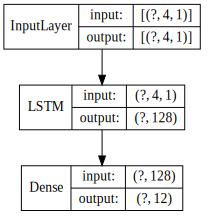

In [19]:
from IPython.display import SVG, display
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
import os

os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin"

%matplotlib inline

iv1_dot = model_to_dot(model, show_shapes=True, show_layer_names=False, dpi=70)   # 사이즈 변경하기 
plot_model(model, to_file='model.png')
display(SVG(iv1_dot.create(prog=['dot'], format='svg')))

## 5 모델 학습과정 설정 

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = LossHistory() # 손실 이력 객체 생성
history.init()

## 6 모델 학습시키기

In [21]:
hist = model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])

Epoch 1/2000
5/5 - 0s - loss: 2.4645 - accuracy: 0.2000
Epoch 2/2000
5/5 - 0s - loss: 2.4085 - accuracy: 0.3400
Epoch 3/2000
5/5 - 0s - loss: 2.3576 - accuracy: 0.3400
Epoch 4/2000
5/5 - 0s - loss: 2.2970 - accuracy: 0.3400
Epoch 5/2000
5/5 - 0s - loss: 2.2200 - accuracy: 0.3400
Epoch 6/2000
5/5 - 0s - loss: 2.1277 - accuracy: 0.3400
Epoch 7/2000
5/5 - 0s - loss: 2.0168 - accuracy: 0.3400
Epoch 8/2000
5/5 - 0s - loss: 1.9755 - accuracy: 0.3400
Epoch 9/2000
5/5 - 0s - loss: 1.9827 - accuracy: 0.3400
Epoch 10/2000
5/5 - 0s - loss: 1.9631 - accuracy: 0.3400
Epoch 11/2000
5/5 - 0s - loss: 1.9329 - accuracy: 0.3400
Epoch 12/2000
5/5 - 0s - loss: 1.9266 - accuracy: 0.3400
Epoch 13/2000
5/5 - 0s - loss: 1.9212 - accuracy: 0.3400
Epoch 14/2000
5/5 - 0s - loss: 1.9211 - accuracy: 0.3400
Epoch 15/2000
5/5 - 0s - loss: 1.9145 - accuracy: 0.3400
Epoch 16/2000
5/5 - 0s - loss: 1.9134 - accuracy: 0.3400
Epoch 17/2000
5/5 - 0s - loss: 1.9057 - accuracy: 0.3400
Epoch 18/2000
5/5 - 0s - loss: 1.9077 - 

Epoch 145/2000
5/5 - 0s - loss: 1.6684 - accuracy: 0.4000
Epoch 146/2000
5/5 - 0s - loss: 1.6563 - accuracy: 0.4000
Epoch 147/2000
5/5 - 0s - loss: 1.6351 - accuracy: 0.4000
Epoch 148/2000
5/5 - 0s - loss: 1.6363 - accuracy: 0.4000
Epoch 149/2000
5/5 - 0s - loss: 1.6428 - accuracy: 0.4000
Epoch 150/2000
5/5 - 0s - loss: 1.6663 - accuracy: 0.4000
Epoch 151/2000
5/5 - 0s - loss: 1.6364 - accuracy: 0.4400
Epoch 152/2000
5/5 - 0s - loss: 1.6455 - accuracy: 0.3600
Epoch 153/2000
5/5 - 0s - loss: 1.6233 - accuracy: 0.3800
Epoch 154/2000
5/5 - 0s - loss: 1.6392 - accuracy: 0.4200
Epoch 155/2000
5/5 - 0s - loss: 1.6385 - accuracy: 0.4400
Epoch 156/2000
5/5 - 0s - loss: 1.6188 - accuracy: 0.4000
Epoch 157/2000
5/5 - 0s - loss: 1.6271 - accuracy: 0.4000
Epoch 158/2000
5/5 - 0s - loss: 1.6251 - accuracy: 0.4200
Epoch 159/2000
5/5 - 0s - loss: 1.6156 - accuracy: 0.4400
Epoch 160/2000
5/5 - 0s - loss: 1.6286 - accuracy: 0.4200
Epoch 161/2000
5/5 - 0s - loss: 1.6168 - accuracy: 0.4400
Epoch 162/2000

Epoch 287/2000
5/5 - 0s - loss: 1.3230 - accuracy: 0.5200
Epoch 288/2000
5/5 - 0s - loss: 1.3668 - accuracy: 0.4600
Epoch 289/2000
5/5 - 0s - loss: 1.2909 - accuracy: 0.5000
Epoch 290/2000
5/5 - 0s - loss: 1.3165 - accuracy: 0.5200
Epoch 291/2000
5/5 - 0s - loss: 1.2908 - accuracy: 0.4800
Epoch 292/2000
5/5 - 0s - loss: 1.2644 - accuracy: 0.5400
Epoch 293/2000
5/5 - 0s - loss: 1.2808 - accuracy: 0.5200
Epoch 294/2000
5/5 - 0s - loss: 1.2803 - accuracy: 0.4400
Epoch 295/2000
5/5 - 0s - loss: 1.3253 - accuracy: 0.5200
Epoch 296/2000
5/5 - 0s - loss: 1.3772 - accuracy: 0.5000
Epoch 297/2000
5/5 - 0s - loss: 1.3067 - accuracy: 0.4800
Epoch 298/2000
5/5 - 0s - loss: 1.2775 - accuracy: 0.5400
Epoch 299/2000
5/5 - 0s - loss: 1.2669 - accuracy: 0.4800
Epoch 300/2000
5/5 - 0s - loss: 1.2722 - accuracy: 0.5200
Epoch 301/2000
5/5 - 0s - loss: 1.2576 - accuracy: 0.5600
Epoch 302/2000
5/5 - 0s - loss: 1.2632 - accuracy: 0.5200
Epoch 303/2000
5/5 - 0s - loss: 1.2638 - accuracy: 0.5200
Epoch 304/2000

Epoch 429/2000
5/5 - 0s - loss: 0.9635 - accuracy: 0.6200
Epoch 430/2000
5/5 - 0s - loss: 0.9838 - accuracy: 0.6400
Epoch 431/2000
5/5 - 0s - loss: 0.9564 - accuracy: 0.6400
Epoch 432/2000
5/5 - 0s - loss: 0.9626 - accuracy: 0.6000
Epoch 433/2000
5/5 - 0s - loss: 0.9509 - accuracy: 0.6400
Epoch 434/2000
5/5 - 0s - loss: 0.9573 - accuracy: 0.6400
Epoch 435/2000
5/5 - 0s - loss: 0.9456 - accuracy: 0.6400
Epoch 436/2000
5/5 - 0s - loss: 0.9468 - accuracy: 0.6400
Epoch 437/2000
5/5 - 0s - loss: 0.9650 - accuracy: 0.6200
Epoch 438/2000
5/5 - 0s - loss: 0.9518 - accuracy: 0.6000
Epoch 439/2000
5/5 - 0s - loss: 0.9258 - accuracy: 0.6200
Epoch 440/2000
5/5 - 0s - loss: 0.9301 - accuracy: 0.6400
Epoch 441/2000
5/5 - 0s - loss: 0.9419 - accuracy: 0.7000
Epoch 442/2000
5/5 - 0s - loss: 0.9370 - accuracy: 0.6400
Epoch 443/2000
5/5 - 0s - loss: 0.9225 - accuracy: 0.6200
Epoch 444/2000
5/5 - 0s - loss: 0.9222 - accuracy: 0.6600
Epoch 445/2000
5/5 - 0s - loss: 0.9200 - accuracy: 0.6200
Epoch 446/2000

Epoch 571/2000
5/5 - 0s - loss: 0.6794 - accuracy: 0.7600
Epoch 572/2000
5/5 - 0s - loss: 0.6891 - accuracy: 0.7400
Epoch 573/2000
5/5 - 0s - loss: 0.6903 - accuracy: 0.7600
Epoch 574/2000
5/5 - 0s - loss: 0.7471 - accuracy: 0.7600
Epoch 575/2000
5/5 - 0s - loss: 0.6891 - accuracy: 0.8000
Epoch 576/2000
5/5 - 0s - loss: 0.7047 - accuracy: 0.6800
Epoch 577/2000
5/5 - 0s - loss: 0.6789 - accuracy: 0.7600
Epoch 578/2000
5/5 - 0s - loss: 0.6833 - accuracy: 0.7800
Epoch 579/2000
5/5 - 0s - loss: 0.6967 - accuracy: 0.7600
Epoch 580/2000
5/5 - 0s - loss: 0.7087 - accuracy: 0.7200
Epoch 581/2000
5/5 - 0s - loss: 0.6730 - accuracy: 0.7400
Epoch 582/2000
5/5 - 0s - loss: 0.6655 - accuracy: 0.8000
Epoch 583/2000
5/5 - 0s - loss: 0.6631 - accuracy: 0.7800
Epoch 584/2000
5/5 - 0s - loss: 0.6772 - accuracy: 0.7600
Epoch 585/2000
5/5 - 0s - loss: 0.6620 - accuracy: 0.7800
Epoch 586/2000
5/5 - 0s - loss: 0.6936 - accuracy: 0.7600
Epoch 587/2000
5/5 - 0s - loss: 0.6695 - accuracy: 0.8000
Epoch 588/2000

Epoch 713/2000
5/5 - 0s - loss: 0.5508 - accuracy: 0.8400
Epoch 714/2000
5/5 - 0s - loss: 0.5462 - accuracy: 0.7800
Epoch 715/2000
5/5 - 0s - loss: 0.5622 - accuracy: 0.7800
Epoch 716/2000
5/5 - 0s - loss: 0.5604 - accuracy: 0.7800
Epoch 717/2000
5/5 - 0s - loss: 0.5663 - accuracy: 0.8000
Epoch 718/2000
5/5 - 0s - loss: 0.5503 - accuracy: 0.8200
Epoch 719/2000
5/5 - 0s - loss: 0.5193 - accuracy: 0.8400
Epoch 720/2000
5/5 - 0s - loss: 0.5494 - accuracy: 0.8400
Epoch 721/2000
5/5 - 0s - loss: 0.5441 - accuracy: 0.8000
Epoch 722/2000
5/5 - 0s - loss: 0.5414 - accuracy: 0.7800
Epoch 723/2000
5/5 - 0s - loss: 0.5358 - accuracy: 0.8400
Epoch 724/2000
5/5 - 0s - loss: 0.5201 - accuracy: 0.8200
Epoch 725/2000
5/5 - 0s - loss: 0.5630 - accuracy: 0.8000
Epoch 726/2000
5/5 - 0s - loss: 0.5520 - accuracy: 0.7800
Epoch 727/2000
5/5 - 0s - loss: 0.5340 - accuracy: 0.8000
Epoch 728/2000
5/5 - 0s - loss: 0.5374 - accuracy: 0.7800
Epoch 729/2000
5/5 - 0s - loss: 0.5305 - accuracy: 0.8000
Epoch 730/2000

Epoch 855/2000
5/5 - 0s - loss: 0.4667 - accuracy: 0.8600
Epoch 856/2000
5/5 - 0s - loss: 0.4755 - accuracy: 0.8400
Epoch 857/2000
5/5 - 0s - loss: 0.4543 - accuracy: 0.8800
Epoch 858/2000
5/5 - 0s - loss: 0.4454 - accuracy: 0.8600
Epoch 859/2000
5/5 - 0s - loss: 0.4590 - accuracy: 0.8200
Epoch 860/2000
5/5 - 0s - loss: 0.4433 - accuracy: 0.8800
Epoch 861/2000
5/5 - 0s - loss: 0.4511 - accuracy: 0.8800
Epoch 862/2000
5/5 - 0s - loss: 0.4816 - accuracy: 0.8200
Epoch 863/2000
5/5 - 0s - loss: 0.4432 - accuracy: 0.8400
Epoch 864/2000
5/5 - 0s - loss: 0.4551 - accuracy: 0.8400
Epoch 865/2000
5/5 - 0s - loss: 0.5033 - accuracy: 0.8000
Epoch 866/2000
5/5 - 0s - loss: 0.5638 - accuracy: 0.8000
Epoch 867/2000
5/5 - 0s - loss: 0.4587 - accuracy: 0.8600
Epoch 868/2000
5/5 - 0s - loss: 0.4512 - accuracy: 0.8200
Epoch 869/2000
5/5 - 0s - loss: 0.4998 - accuracy: 0.8000
Epoch 870/2000
5/5 - 0s - loss: 0.4585 - accuracy: 0.8600
Epoch 871/2000
5/5 - 0s - loss: 0.4415 - accuracy: 0.8800
Epoch 872/2000

Epoch 997/2000
5/5 - 0s - loss: 0.4229 - accuracy: 0.8600
Epoch 998/2000
5/5 - 0s - loss: 0.4147 - accuracy: 0.8400
Epoch 999/2000
5/5 - 0s - loss: 0.4470 - accuracy: 0.8400
Epoch 1000/2000
5/5 - 0s - loss: 0.4166 - accuracy: 0.8400
Epoch 1001/2000
5/5 - 0s - loss: 0.4152 - accuracy: 0.8400
Epoch 1002/2000
5/5 - 0s - loss: 0.4399 - accuracy: 0.8400
Epoch 1003/2000
5/5 - 0s - loss: 0.4122 - accuracy: 0.8600
Epoch 1004/2000
5/5 - 0s - loss: 0.3975 - accuracy: 0.8400
Epoch 1005/2000
5/5 - 0s - loss: 0.3994 - accuracy: 0.8600
Epoch 1006/2000
5/5 - 0s - loss: 0.3984 - accuracy: 0.8600
Epoch 1007/2000
5/5 - 0s - loss: 0.3949 - accuracy: 0.8400
Epoch 1008/2000
5/5 - 0s - loss: 0.3878 - accuracy: 0.8600
Epoch 1009/2000
5/5 - 0s - loss: 0.4017 - accuracy: 0.8600
Epoch 1010/2000
5/5 - 0s - loss: 0.3958 - accuracy: 0.8400
Epoch 1011/2000
5/5 - 0s - loss: 0.3945 - accuracy: 0.8600
Epoch 1012/2000
5/5 - 0s - loss: 0.3924 - accuracy: 0.8600
Epoch 1013/2000
5/5 - 0s - loss: 0.4037 - accuracy: 0.8400


Epoch 1136/2000
5/5 - 0s - loss: 0.3935 - accuracy: 0.8600
Epoch 1137/2000
5/5 - 0s - loss: 0.3945 - accuracy: 0.8400
Epoch 1138/2000
5/5 - 0s - loss: 0.3841 - accuracy: 0.8400
Epoch 1139/2000
5/5 - 0s - loss: 0.4027 - accuracy: 0.8400
Epoch 1140/2000
5/5 - 0s - loss: 0.3828 - accuracy: 0.8600
Epoch 1141/2000
5/5 - 0s - loss: 0.3669 - accuracy: 0.8600
Epoch 1142/2000
5/5 - 0s - loss: 0.3687 - accuracy: 0.8800
Epoch 1143/2000
5/5 - 0s - loss: 0.3754 - accuracy: 0.8600
Epoch 1144/2000
5/5 - 0s - loss: 0.3620 - accuracy: 0.8600
Epoch 1145/2000
5/5 - 0s - loss: 0.3834 - accuracy: 0.8400
Epoch 1146/2000
5/5 - 0s - loss: 0.3588 - accuracy: 0.8400
Epoch 1147/2000
5/5 - 0s - loss: 0.3937 - accuracy: 0.8400
Epoch 1148/2000
5/5 - 0s - loss: 0.3687 - accuracy: 0.8600
Epoch 1149/2000
5/5 - 0s - loss: 0.3674 - accuracy: 0.8600
Epoch 1150/2000
5/5 - 0s - loss: 0.3681 - accuracy: 0.8600
Epoch 1151/2000
5/5 - 0s - loss: 0.3608 - accuracy: 0.8400
Epoch 1152/2000
5/5 - 0s - loss: 0.3609 - accuracy: 0.86

Epoch 1275/2000
5/5 - 0s - loss: 0.3386 - accuracy: 0.8400
Epoch 1276/2000
5/5 - 0s - loss: 0.3410 - accuracy: 0.8800
Epoch 1277/2000
5/5 - 0s - loss: 0.3493 - accuracy: 0.8600
Epoch 1278/2000
5/5 - 0s - loss: 0.3363 - accuracy: 0.8400
Epoch 1279/2000
5/5 - 0s - loss: 0.3437 - accuracy: 0.8600
Epoch 1280/2000
5/5 - 0s - loss: 0.3366 - accuracy: 0.8400
Epoch 1281/2000
5/5 - 0s - loss: 0.3435 - accuracy: 0.8600
Epoch 1282/2000
5/5 - 0s - loss: 0.3336 - accuracy: 0.8800
Epoch 1283/2000
5/5 - 0s - loss: 0.3391 - accuracy: 0.8800
Epoch 1284/2000
5/5 - 0s - loss: 0.3344 - accuracy: 0.8400
Epoch 1285/2000
5/5 - 0s - loss: 0.3323 - accuracy: 0.8800
Epoch 1286/2000
5/5 - 0s - loss: 0.3351 - accuracy: 0.8600
Epoch 1287/2000
5/5 - 0s - loss: 0.3303 - accuracy: 0.8600
Epoch 1288/2000
5/5 - 0s - loss: 0.3419 - accuracy: 0.8600
Epoch 1289/2000
5/5 - 0s - loss: 0.3436 - accuracy: 0.8600
Epoch 1290/2000
5/5 - 0s - loss: 0.3554 - accuracy: 0.8600
Epoch 1291/2000
5/5 - 0s - loss: 0.3357 - accuracy: 0.86

Epoch 1414/2000
5/5 - 0s - loss: 0.3214 - accuracy: 0.8400
Epoch 1415/2000
5/5 - 0s - loss: 0.3408 - accuracy: 0.8800
Epoch 1416/2000
5/5 - 0s - loss: 0.3377 - accuracy: 0.8800
Epoch 1417/2000
5/5 - 0s - loss: 0.3157 - accuracy: 0.8800
Epoch 1418/2000
5/5 - 0s - loss: 0.3220 - accuracy: 0.8600
Epoch 1419/2000
5/5 - 0s - loss: 0.3282 - accuracy: 0.8600
Epoch 1420/2000
5/5 - 0s - loss: 0.3155 - accuracy: 0.8800
Epoch 1421/2000
5/5 - 0s - loss: 0.3144 - accuracy: 0.8600
Epoch 1422/2000
5/5 - 0s - loss: 0.3121 - accuracy: 0.8800
Epoch 1423/2000
5/5 - 0s - loss: 0.3402 - accuracy: 0.8800
Epoch 1424/2000
5/5 - 0s - loss: 0.3311 - accuracy: 0.8400
Epoch 1425/2000
5/5 - 0s - loss: 0.3253 - accuracy: 0.8800
Epoch 1426/2000
5/5 - 0s - loss: 0.3444 - accuracy: 0.8600
Epoch 1427/2000
5/5 - 0s - loss: 0.3210 - accuracy: 0.8600
Epoch 1428/2000
5/5 - 0s - loss: 0.3146 - accuracy: 0.8600
Epoch 1429/2000
5/5 - 0s - loss: 0.3035 - accuracy: 0.8600
Epoch 1430/2000
5/5 - 0s - loss: 0.3212 - accuracy: 0.88

Epoch 1553/2000
5/5 - 0s - loss: 0.3007 - accuracy: 0.8600
Epoch 1554/2000
5/5 - 0s - loss: 0.3586 - accuracy: 0.8800
Epoch 1555/2000
5/5 - 0s - loss: 0.2992 - accuracy: 0.8600
Epoch 1556/2000
5/5 - 0s - loss: 0.3293 - accuracy: 0.8400
Epoch 1557/2000
5/5 - 0s - loss: 0.3153 - accuracy: 0.8600
Epoch 1558/2000
5/5 - 0s - loss: 0.3077 - accuracy: 0.8600
Epoch 1559/2000
5/5 - 0s - loss: 0.2919 - accuracy: 0.9000
Epoch 1560/2000
5/5 - 0s - loss: 0.3014 - accuracy: 0.8800
Epoch 1561/2000
5/5 - 0s - loss: 0.3025 - accuracy: 0.8800
Epoch 1562/2000
5/5 - 0s - loss: 0.2951 - accuracy: 0.9000
Epoch 1563/2000
5/5 - 0s - loss: 0.3024 - accuracy: 0.8800
Epoch 1564/2000
5/5 - 0s - loss: 0.2948 - accuracy: 0.8800
Epoch 1565/2000
5/5 - 0s - loss: 0.3058 - accuracy: 0.8800
Epoch 1566/2000
5/5 - 0s - loss: 0.3063 - accuracy: 0.8400
Epoch 1567/2000
5/5 - 0s - loss: 0.2971 - accuracy: 0.8400
Epoch 1568/2000
5/5 - 0s - loss: 0.3008 - accuracy: 0.9000
Epoch 1569/2000
5/5 - 0s - loss: 0.2946 - accuracy: 0.90

Epoch 1692/2000
5/5 - 0s - loss: 0.2873 - accuracy: 0.8600
Epoch 1693/2000
5/5 - 0s - loss: 0.2945 - accuracy: 0.9000
Epoch 1694/2000
5/5 - 0s - loss: 0.3022 - accuracy: 0.8600
Epoch 1695/2000
5/5 - 0s - loss: 0.3009 - accuracy: 0.8600
Epoch 1696/2000
5/5 - 0s - loss: 0.2968 - accuracy: 0.8800
Epoch 1697/2000
5/5 - 0s - loss: 0.3073 - accuracy: 0.8600
Epoch 1698/2000
5/5 - 0s - loss: 0.3028 - accuracy: 0.8800
Epoch 1699/2000
5/5 - 0s - loss: 0.2899 - accuracy: 0.8600
Epoch 1700/2000
5/5 - 0s - loss: 0.3040 - accuracy: 0.8800
Epoch 1701/2000
5/5 - 0s - loss: 0.2858 - accuracy: 0.8800
Epoch 1702/2000
5/5 - 0s - loss: 0.3076 - accuracy: 0.8600
Epoch 1703/2000
5/5 - 0s - loss: 0.2880 - accuracy: 0.8400
Epoch 1704/2000
5/5 - 0s - loss: 0.2857 - accuracy: 0.9000
Epoch 1705/2000
5/5 - 0s - loss: 0.2916 - accuracy: 0.8800
Epoch 1706/2000
5/5 - 0s - loss: 0.2947 - accuracy: 0.8600
Epoch 1707/2000
5/5 - 0s - loss: 0.2970 - accuracy: 0.8600
Epoch 1708/2000
5/5 - 0s - loss: 0.3167 - accuracy: 0.88

Epoch 1831/2000
5/5 - 0s - loss: 0.2794 - accuracy: 0.8400
Epoch 1832/2000
5/5 - 0s - loss: 0.2796 - accuracy: 0.9000
Epoch 1833/2000
5/5 - 0s - loss: 0.2741 - accuracy: 0.9000
Epoch 1834/2000
5/5 - 0s - loss: 0.3119 - accuracy: 0.8200
Epoch 1835/2000
5/5 - 0s - loss: 0.2820 - accuracy: 0.9000
Epoch 1836/2000
5/5 - 0s - loss: 0.2945 - accuracy: 0.8800
Epoch 1837/2000
5/5 - 0s - loss: 0.2938 - accuracy: 0.8600
Epoch 1838/2000
5/5 - 0s - loss: 0.2905 - accuracy: 0.8400
Epoch 1839/2000
5/5 - 0s - loss: 0.3017 - accuracy: 0.8800
Epoch 1840/2000
5/5 - 0s - loss: 0.2810 - accuracy: 0.8800
Epoch 1841/2000
5/5 - 0s - loss: 0.2901 - accuracy: 0.8600
Epoch 1842/2000
5/5 - 0s - loss: 0.2975 - accuracy: 0.8800
Epoch 1843/2000
5/5 - 0s - loss: 0.2753 - accuracy: 0.8600
Epoch 1844/2000
5/5 - 0s - loss: 0.2871 - accuracy: 0.8800
Epoch 1845/2000
5/5 - 0s - loss: 0.2844 - accuracy: 0.8800
Epoch 1846/2000
5/5 - 0s - loss: 0.3026 - accuracy: 0.8800
Epoch 1847/2000
5/5 - 0s - loss: 0.2806 - accuracy: 0.88

Epoch 1970/2000
5/5 - 0s - loss: 0.2781 - accuracy: 0.8600
Epoch 1971/2000
5/5 - 0s - loss: 0.2705 - accuracy: 0.8800
Epoch 1972/2000
5/5 - 0s - loss: 0.2766 - accuracy: 0.8600
Epoch 1973/2000
5/5 - 0s - loss: 0.2702 - accuracy: 0.8800
Epoch 1974/2000
5/5 - 0s - loss: 0.2630 - accuracy: 0.8800
Epoch 1975/2000
5/5 - 0s - loss: 0.2753 - accuracy: 0.8600
Epoch 1976/2000
5/5 - 0s - loss: 0.2875 - accuracy: 0.8600
Epoch 1977/2000
5/5 - 0s - loss: 0.2837 - accuracy: 0.8600
Epoch 1978/2000
5/5 - 0s - loss: 0.2939 - accuracy: 0.8600
Epoch 1979/2000
5/5 - 0s - loss: 0.2888 - accuracy: 0.8800
Epoch 1980/2000
5/5 - 0s - loss: 0.2717 - accuracy: 0.8800
Epoch 1981/2000
5/5 - 0s - loss: 0.2788 - accuracy: 0.8800
Epoch 1982/2000
5/5 - 0s - loss: 0.2774 - accuracy: 0.8800
Epoch 1983/2000
5/5 - 0s - loss: 0.2707 - accuracy: 0.8600
Epoch 1984/2000
5/5 - 0s - loss: 0.2738 - accuracy: 0.8600
Epoch 1985/2000
5/5 - 0s - loss: 0.2734 - accuracy: 0.8600
Epoch 1986/2000
5/5 - 0s - loss: 0.2796 - accuracy: 0.88

## 7 학습과정 살펴보기

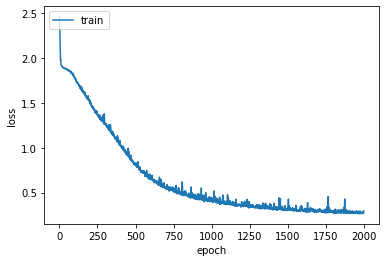

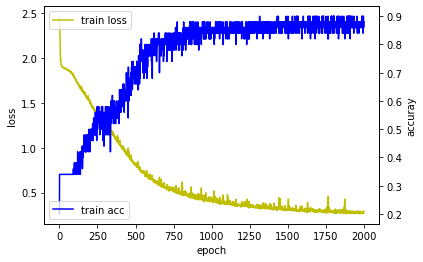

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train'], loc='upper left')

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
#loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
#acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 8 모델 평가하기

In [23]:
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

2/2 [==============================] - 0s 1ms/step - loss: 0.2673 - accuracy: 0.9000
accuracy: 90.00%


## 9 모델 사용 하기 

In [16]:
pred_count = 50 # 최대 예측 개수 정의

### 9.1 한 스탭 예측 

In [17]:
seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i])     # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx])    # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'c4', 'e4', 'd4', 'c4', 'c4', 'f4', 'f4', 'f4', 'e4', 'd4', 'c4', 'c4', 'd4', 'c4', 'f4', 'e4', 'd4', 'c4', 'f4', 'f4', 'e4', 'd4', 'c4', 'c4', 'c4', 'c4', 'd4', 'c4', 'c4', 'f4', 'e4', 'd4', 'c4', 'd4', 'c4', 'c4', 'f4', 'e4', 'f4', 'e4', 'd4', 'c4', 'e4', 'd4', 'c4', 'f4', 'f4', 'e4', 'd4', 'c4']


### 9.2 곡 전체 예측 

In [18]:
seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in]    # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

full song prediction :  ['g8', 'e8', 'e4', 'f8', 'c4', 'e4', 'd4', 'c4', 'd4', 'c4', 'c4', 'd4', 'c4', 'e4', 'f4', 'f4', 'e4', 'd4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4']
